# Import Libraries

In [185]:
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from spacy.lang.en.examples import sentences 
import spacy as sp
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
# import zipfile
from textblob import TextBlob
import string
import re 
from sklearn.manifold import TSNE

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()


In [186]:
tweets = pd.read_csv('data/TrumpTweetsCleaned.csv')
#09-11-2017 to 02-16-2018
before = pd.to_datetime('2017-09-11')
after = pd.to_datetime('2018-02-16')
tweets['created_at'] = pd.to_datetime(tweets['created_at'])

# Preprocessing (James)

In [187]:
#preprocessing functions for the dataframe
def delete_punct(text):
    '''
    removes special characters from the document
    '''
    no_punct = "".join([c for c in text if c not in string.punctuation])
    return no_punct 
def remove_stopwords(text):
    '''
    removes all stopwords according to the pre-built english dictionary of known stopwords
    '''
    words = [w for w in text if w not in set(stopwords.words('english'))]
    return words
def lemmatize(text):
    '''
    returns the lemmas of each word in the document
    '''
    lemmatized = [lemmatizer.lemmatize(i) for i in text]
    return lemmatized
def joiner(text):
    '''
    joins the comma-separated list into one string
    '''
    joined = " ".join([i for i in text])
    return joined
lemmatizer = WordNetLemmatizer()
tokenizer = TweetTokenizer()

In [188]:
def preproc_pipeline(tweets):
    '''
    The preprocessing pipline applied to each document in the dataframe
    '''
    tweets['preproc'] = tweets['text'].apply(lambda x: delete_punct(x))
    tweets['preproc'] = tweets['preproc'].apply(lambda x: tokenizer.tokenize(x.lower()))
    tweets['preproc'] = tweets['preproc'].apply(lambda x: remove_stopwords(x))
    tweets['preproc'] = tweets['preproc'].apply(lambda x: lemmatize(x))
    tweets['preproc'] = tweets['preproc'].apply(lambda x: joiner(x))
    return tweets

In [189]:
tweets = preproc_pipeline(tweets)

# TFIDF Term Extraction

In [190]:
# fitting sk-learn's TF-IDF Vectorizer to our dataframe and returning list of most important keywords
docs = tweets['preproc'].tolist()
tfidf = TfidfVectorizer(max_features = 2500, min_df = 10, max_df = .9)
tfidf2 = TfidfVectorizer(max_features = 150, min_df = 160, max_df = .9)
X = tfidf.fit_transform(docs).toarray()
feature_names = tfidf.get_feature_names()
X2 = tfidf2.fit_transform(docs).toarray()
features_names2 = tfidf2.get_feature_names()

In [191]:
def intersection(l1,l2):
    '''
    finding intersection of elements between two lists
    '''
    return list(set(l1) & set(l2))
def term_extract(df):
    '''
    Will return a column of important keywords in each document determined by TF-IDF 
    Sentiment Analysis via Textblob will only be run on these keywords 
    '''
    df['keywords'] = df['preproc'].apply(lambda x: intersection(x.split(' '), feature_names))
    df['keywords'] = df['keywords'].apply(lambda x: joiner(x))
    return df
tweets = term_extract(tweets)

In [192]:
tweets['polarity'] = [TextBlob(tweets['keywords'].values[i]).polarity for i in range(len(tweets))]
tweets['subjectivity'] = [TextBlob(tweets['keywords'].values[i]).subjectivity for i in range(len(tweets))]

In [193]:
# Delete columns 
# tweets  = tweets.drop(columns = ['text', 'preproc'])
tweets = tweets.replace('', np.nan)
tweets = tweets.dropna()

In [194]:
tweets

,text,created_at,retweet_count,favorite_count,is_retweet,preproc,keywords,polarity,subjectivity
0,Look at the way Crooked Hillary is handling th...,2016-11-01 10:31:00,21459.0,55584.0,False,look way crooked hillary handling email case t...,crooked way hillary total president email mess...,-0.218750,0.422917
1,Wow now leading in @ABC /@washingtonpost Poll ...,2016-11-01 11:55:00,16479.0,39631.0,False,wow leading abc washingtonpost poll 46 45 gone...,leading crooked 12 washingtonpost gone hillary...,0.200000,0.533333
2,Crooked Hillary should not be allowed to run f...,2016-11-01 12:01:00,23747.0,59656.0,False,crooked hillary allowed run president deleted ...,crooked allowed subpoena rigged hillary run pr...,0.000000,0.100000
3,JOIN ME TOMORROW IN FLORIDA!MIAMI‚Ä¢12pmhttps:...,2016-11-01 13:35:00,8773.0,17583.0,False,join tomorrow floridamiami ‚ ä ¢ 12pmhttpstcoa...,join tomorrow,0.000000,0.000000
4,So terrible that Crooked didn't report she got...,2016-11-01 14:14:00,32713.0,80724.0,False,terrible crooked didnt report got debate quest...,debate crooked page would news got question re...,-0.500000,0.550000
...,...,...,...,...,...,...,...,...,...
9792,So they now convict Roger Stone of lying and w...,2019-11-15 17:13:00,43881.0,140524.0,False,convict roger stone lying want jail many year ...,crooked lying steele strzok hillary shifty man...,0.133333,0.200000
9793,....A double standard like never seen before i...,2019-11-15 17:13:00,19696.0,72919.0,False,double standard like never seen history country,never like country history seen double standard,0.000000,0.000000
9794,https://t.co/8h6ZmdGlPf https://t.co/shaijXMXli,2019-11-15 22:10:00,16851.0,57927.0,False,httpstco 8h6zmdglpf httpstcoshaijxmxli,httpstco,0.000000,0.000000
9795,THANK YOU! #MAGA #KAG https://t.co/Pcq7IbehVp,2019-11-16 00:16:00,14609.0,54753.0,False,thank maga kag httpstcopcq 7ibehvp,thank maga kag,0.000000,0.000000


# Word Similarity

In [11]:
# tweets_stock_viable = pd.read_csv('data/tweets_stock_viable_5')
# tweets_stock_viable['keywords'] = tweets_stock_viable['keywords'].astype(str)

In [195]:
# https://www.kdnuggets.com/2018/04/robust-word2vec-models-gensim.html
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in tweets['keywords']]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

In [196]:
def word_similarity(df):
    columns = []
    for keyword in features_names2:
        icols = []
        for i in df:
            temp = []
            list_ = i.split()
            for j in list_:
                if j in w2v_model.wv.vocab:
                    temp.append(w2v_model.wv.similarity(j, keyword))
            icols.append(max(temp))
        columns.append(icols)
    return columns
columns = word_similarity(tweets['keywords'])

In [197]:
word_similarity = pd.DataFrame(columns).T
word_similarity.columns = features_names2
word_similarity.index = tweets.index

In [198]:
preprocessed = pd.concat([tweets, word_similarity], axis = 1).reset_index(drop = True)

## Stock Data 

In [199]:
stock = pd.read_csv('data/SP500_intraday.csv')

In [200]:
stock['Time_pd'] = pd.to_timedelta(stock['Time']+':00')
stock['Date_time'] = pd.to_datetime(pd.to_datetime(stock['Date'])+ pd.to_timedelta(stock['Time_pd']))

In [201]:
latest_time = stock['Date_time'].iloc[-1]
earliest_time = stock['Date_time'][0] 
temp = preprocessed[(preprocessed['created_at'] > earliest_time) & (preprocessed['created_at'] < latest_time)]
temp = temp.reset_index(drop = True)

In [202]:
temp

,text,created_at,retweet_count,favorite_count,is_retweet,preproc,keywords,polarity,subjectivity,administration,...,witch,work,working,world,would,year,äôs,äôt,äù,üá
0,The debates especially the second and third pl...,2016-11-13 18:46:00,23410.0,113207.0,False,debate especially second third plus speech int...,debate rally supporter plus especially win gre...,0.402857,0.395714,0.069210,...,0.110957,0.193797,0.214307,0.087553,0.198045,0.151071,0.156789,0.152025,0.190795,0.139478
1,If the election were based on total popular vo...,2016-11-15 13:34:00,49623.0,179219.0,False,election based total popular vote would campai...,bigger vote florida would election total calif...,0.258333,0.745833,0.147832,...,0.183087,0.168979,0.266791,0.052800,1.000000,0.100287,0.137464,0.192232,0.121123,0.070765
2,The Electoral College is actually genius in th...,2016-11-15 13:40:00,39125.0,128083.0,False,electoral college actually genius brings state...,one campaigning play state actually much inclu...,0.100000,0.400000,0.093748,...,0.173328,0.141237,0.151583,0.140979,0.297555,0.175422,0.110959,0.245511,0.057901,0.099427
3,Very organized process taking place as I decid...,2016-11-16 02:55:00,27544.0,119611.0,False,organized process taking place decide cabinet ...,one place know process cabinet position taking...,0.500000,0.500000,0.134011,...,0.087576,0.108176,0.120570,0.158560,0.111555,0.074152,0.102134,0.095816,0.121271,0.293162
4,"I am not trying to get ""top level security cle...",2016-11-16 11:28:00,31102.0,99921.0,False,trying get top level security clearance child ...,news trying story get false top security child...,0.050000,0.550000,0.165021,...,0.147722,0.065299,0.327169,0.138547,0.286868,0.106957,0.121080,0.206010,0.160959,0.143307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9369,The Amazon Washington Post and three lowlife r...,2019-11-07 15:27:00,24007.0,83333.0,False,amazon washington post three lowlife reporter ...,josh another without news fiction wrote barr g...,-0.500000,1.000000,0.183418,...,0.147722,0.117534,0.149660,0.153127,0.146809,0.152272,0.192640,0.164913,0.279148,0.229982
9370,The Radical Left Dems and LameStream Media are...,2019-11-07 15:41:00,18328.0,72619.0,False,radical left dems lamestream medium trying mak...,trying make radical left medium win turning 20...,0.161174,0.349053,0.190329,...,0.335707,0.170983,0.327169,0.280331,0.286868,0.120031,0.183188,0.206010,0.132086,0.185428
9371,Stock Market up big today. A New Record. Enjoy!,2019-11-07 15:43:00,20211.0,114187.0,False,stock market big today new record enjoy,enjoy record big stock today new market,0.178788,0.351515,0.091160,...,0.058908,0.170983,0.141380,-0.000278,0.236184,0.062345,0.192794,0.047970,0.080545,0.302138
9372,STATEMENT FROM PRESIDENT DONALD J. TRUMP https...,2019-11-08 00:08:00,31818.0,110993.0,False,statement president donald j trump httpstcoekt...,statement donald trump president,0.000000,0.000000,0.470312,...,0.168909,0.180170,0.104090,-0.003479,0.161209,0.093182,0.189567,0.043280,0.246554,-0.022690


In [203]:
## Edit the minute after
time_min = 5
time_after = temp['created_at'] + pd.to_timedelta(time_min, unit = 'm')
time_of = temp['created_at']
good_time_after = sorted(list(set(stock['Date_time']) & set(list(time_after))))
x = np.arange(0,len(good_time_after))
tweets_stock_viable = temp.iloc[np.concatenate([np.where(time_after == good_time_after[x])[0] for x in x])]

time_after2 = tweets_stock_viable['created_at'] + pd.to_timedelta(time_min, unit = 'm')
time_of2 = tweets_stock_viable['created_at']
x = time_of2

bad_var = [stock[stock['Date_time'] == time_of2[i]]['Open'].values
             for i in tweets_stock_viable.index]
bad = np.where(pd.DataFrame(bad_var, index = tweets_stock_viable.index).isna())[0]
tweets_stock_viable = tweets_stock_viable.drop(tweets_stock_viable.index[bad])
stock_df = [stock[stock['Date_time'] == time_after2[i]]['Close'].values - stock[stock['Date_time'] == time_of2[i]]['Open'].values
             for i in x.index]

In [204]:
tweets_stock_viable['stock_dif'] = pd.DataFrame(np.concatenate(stock_df), index= tweets_stock_viable.index)
length = len(tweets_stock_viable)
tweets_stock_viable['stock_up'] = [1 if tweets_stock_viable['stock_dif'][i] > 0 else 0 for i in tweets_stock_viable.index]

In [205]:
tweets_stock_viable = tweets_stock_viable.dropna()

In [206]:
print(tweets_stock_viable.columns[0:75])
tweets_stock_viable.columns[75:150]

Index(['text', 'created_at', 'retweet_count', 'favorite_count', 'is_retweet',
       'preproc', 'keywords', 'polarity', 'subjectivity', 'administration',
       'also', 'always', 'america', 'american', 'amp', 'back', 'bad', 'best',
       'better', 'big', 'bill', 'billion', 'border', 'call', 'campaign',
       'china', 'clinton', 'collusion', 'come', 'coming', 'congratulation',
       'congress', 'country', 'crime', 'cut', 'day', 'deal', 'democrat',
       'dems', 'dollar', 'done', 'economy', 'election', 'end', 'even', 'ever',
       'fact', 'fake', 'family', 'far', 'fbi', 'first', 'forward',
       'foxandfriends', 'foxnews', 'get', 'getting', 'go', 'going', 'good',
       'got', 'governor', 'great', 'hard', 'help', 'hillary', 'history',
       'honor', 'house', 'httpstco', 'hunt', 'illegal', 'immigration', 'job',
       'know'],
      dtype='object')


Index(['korea', 'last', 'law', 'let', 'like', 'long', 'look', 'looking',
       'love', 'made', 'maga', 'make', 'many', 'medium', 'meeting', 'mexico',
       'military', 'money', 'much', 'mueller', 'must', 'nation', 'national',
       'need', 'never', 'new', 'news', 'night', 'north', 'nothing', 'number',
       'obama', 'one', 'others', 'party', 'people', 'president', 'really',
       'record', 'report', 'republican', 'right', 'russia', 'said', 'say',
       'security', 'see', 'senate', 'senator', 'state', 'story', 'strong',
       'take', 'tariff', 'tax', 'thank', 'thing', 'time', 'today', 'together',
       'total', 'totally', 'trade', 'trump', 'two', 'united', 'usa', 'vote',
       'wall', 'want', 'way', 'well', 'white', 'win', 'witch'],
      dtype='object')

In [207]:
tweets_stock_viable

,text,created_at,retweet_count,favorite_count,is_retweet,preproc,keywords,polarity,subjectivity,administration,...,working,world,would,year,äôs,äôt,äù,üá,stock_dif,stock_up
0,The debates especially the second and third pl...,2016-11-13 18:46:00,23410.0,113207.0,False,debate especially second third plus speech int...,debate rally supporter plus especially win gre...,0.402857,0.395714,0.069210,...,0.214307,0.087553,0.198045,0.151071,0.156789,0.152025,0.190795,0.139478,0.25,1
1,If the election were based on total popular vo...,2016-11-15 13:34:00,49623.0,179219.0,False,election based total popular vote would campai...,bigger vote florida would election total calif...,0.258333,0.745833,0.147832,...,0.266791,0.052800,1.000000,0.100287,0.137464,0.192232,0.121123,0.070765,0.75,1
2,The Electoral College is actually genius in th...,2016-11-15 13:40:00,39125.0,128083.0,False,electoral college actually genius brings state...,one campaigning play state actually much inclu...,0.100000,0.400000,0.093748,...,0.151583,0.140979,0.297555,0.175422,0.110959,0.245511,0.057901,0.099427,0.75,1
3,Very organized process taking place as I decid...,2016-11-16 02:55:00,27544.0,119611.0,False,organized process taking place decide cabinet ...,one place know process cabinet position taking...,0.500000,0.500000,0.134011,...,0.120570,0.158560,0.111555,0.074152,0.102134,0.095816,0.121271,0.293162,-1.25,0
4,"I am not trying to get ""top level security cle...",2016-11-16 11:28:00,31102.0,99921.0,False,trying get top level security clearance child ...,news trying story get false top security child...,0.050000,0.550000,0.165021,...,0.327169,0.138547,0.286868,0.106957,0.121080,0.206010,0.160959,0.143307,1.25,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9366,‚ÄúWhat did Hunter Biden do for the money?‚Äù ...,2019-11-07 14:51:00,15697.0,56313.0,False,‚ äúwhat hunter biden money ‚ äù senjohnkenned...,äúwhat sleepy joe question biden hunter money ...,0.700000,0.600000,0.025808,...,0.139298,0.130262,0.190929,0.081623,0.100516,0.229888,1.000000,0.056321,-3.00,0
9370,The Radical Left Dems and LameStream Media are...,2019-11-07 15:41:00,18328.0,72619.0,False,radical left dems lamestream medium trying mak...,trying make radical left medium win turning 20...,0.161174,0.349053,0.190329,...,0.327169,0.280331,0.286868,0.120031,0.183188,0.206010,0.132086,0.185428,0.00,0
9371,Stock Market up big today. A New Record. Enjoy!,2019-11-07 15:43:00,20211.0,114187.0,False,stock market big today new record enjoy,enjoy record big stock today new market,0.178788,0.351515,0.091160,...,0.141380,-0.000278,0.236184,0.062345,0.192794,0.047970,0.080545,0.302138,0.25,1
9372,STATEMENT FROM PRESIDENT DONALD J. TRUMP https...,2019-11-08 00:08:00,31818.0,110993.0,False,statement president donald j trump httpstcoekt...,statement donald trump president,0.000000,0.000000,0.470312,...,0.104090,-0.003479,0.161209,0.093182,0.189567,0.043280,0.246554,-0.022690,-0.75,0


In [208]:
tweets_stock_viable.to_csv('data/final_preprocessed.csv')

# EDA

//anaconda3/envs/tfcs109a/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


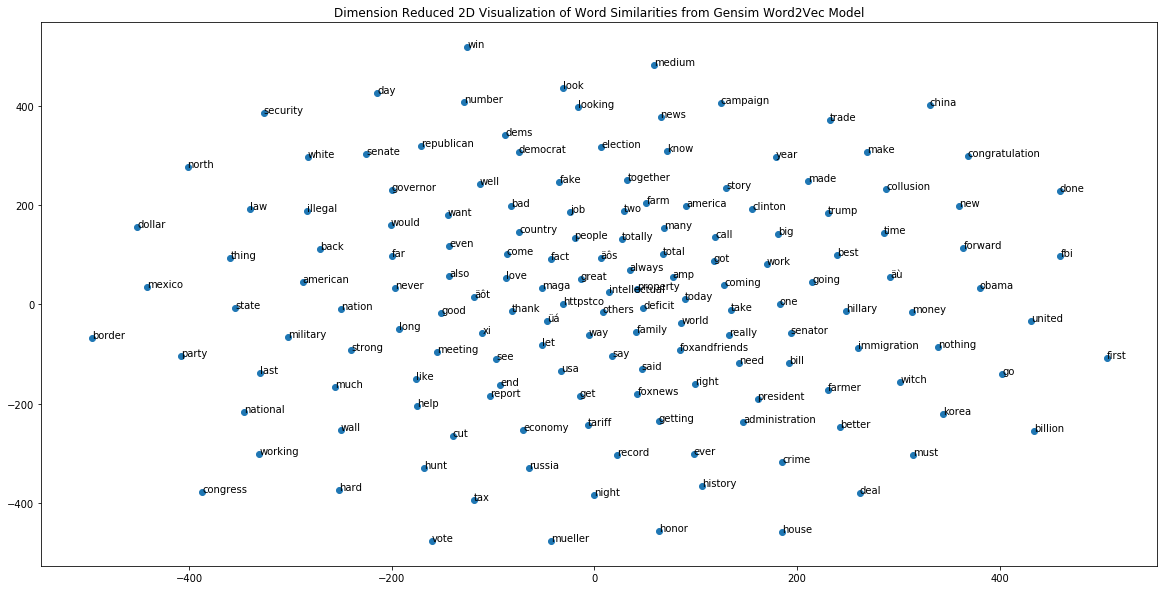

In [24]:
# https://stackoverflow.com/questions/43776572/visualise-word2vec-generated-from-gensim
vocab = list(word_similarity) + ['xi', 'farm', 'farmer', 'deficit', 'intellectual', 'property']
X = w2v_model[vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

w2v_df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])


fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(w2v_df['x'], w2v_df['y'])
ax.set_title('Dimension Reduced 2D Visualization of Word Similarities from Gensim Word2Vec Model')

for word, pos in w2v_df.iterrows():
    ax.annotate(word, pos)

In [29]:
times = pd.to_datetime(tweets_stock_viable['created_at'].values)
time_deltas = []
time_deltas.append(0)
for i in range(1, len(tweets_stock_viable)):
    time_deltas.append((times[i]-times[i-1]).total_seconds()/60)

//anaconda3/envs/tfcs109a/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


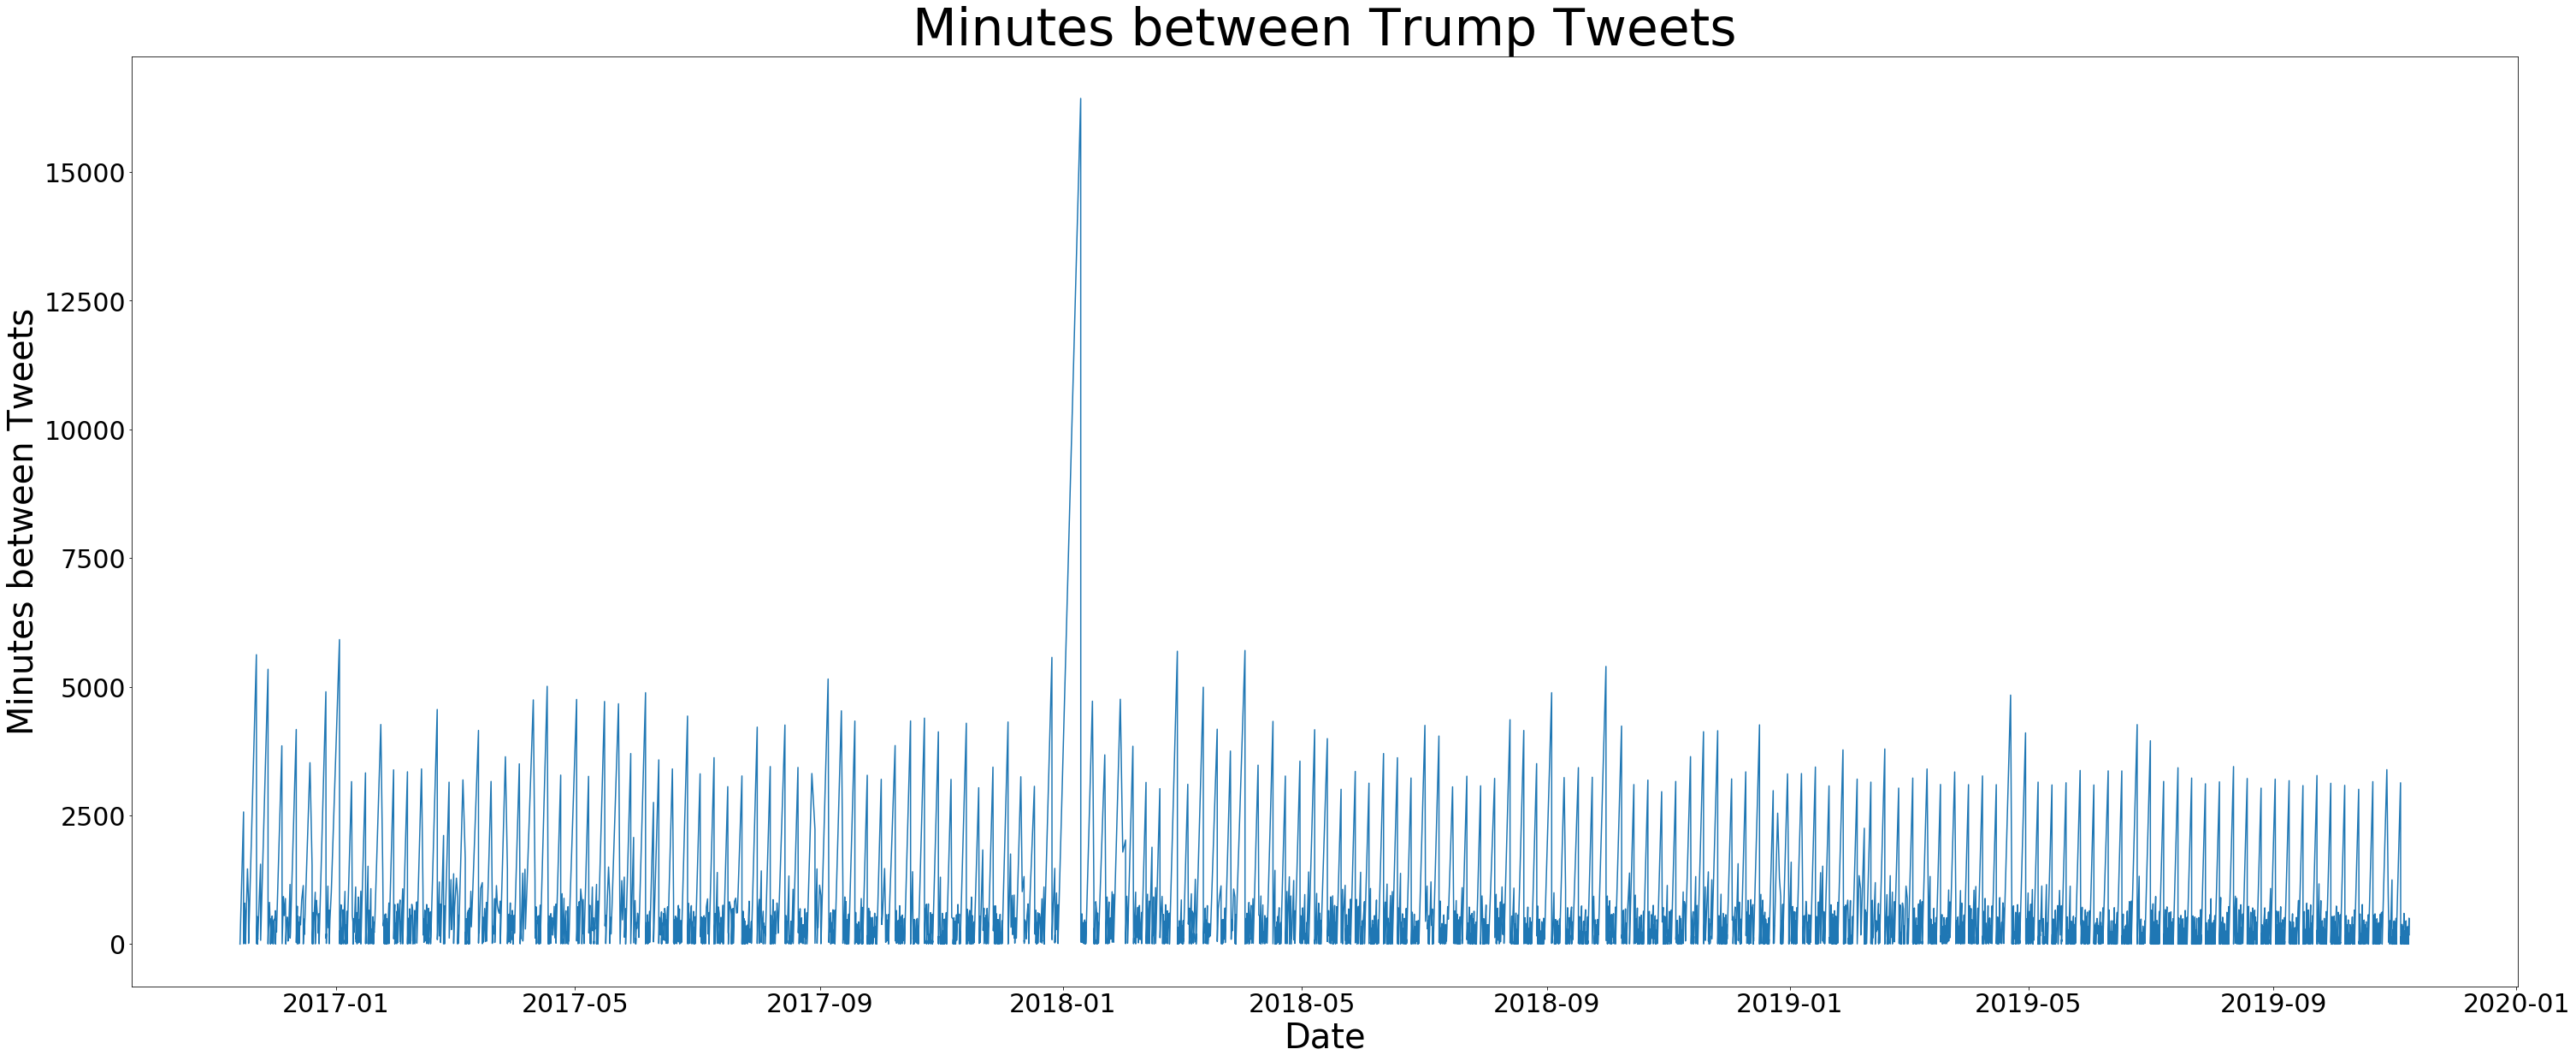

In [30]:
plt.figure(figsize = (50,20))
plt.plot(times, time_deltas)
plt.xticks(fontsize=30)
plt.yticks(fontsize = 30)
plt.xlabel('Date', fontsize = 40)
plt.ylabel('Minutes between Tweets', fontsize = 40)
plt.title('Minutes between Trump Tweets', fontsize = 60)
plt.show()

Text(0.5, 0, 'Raw Change in S&P 500 Price')

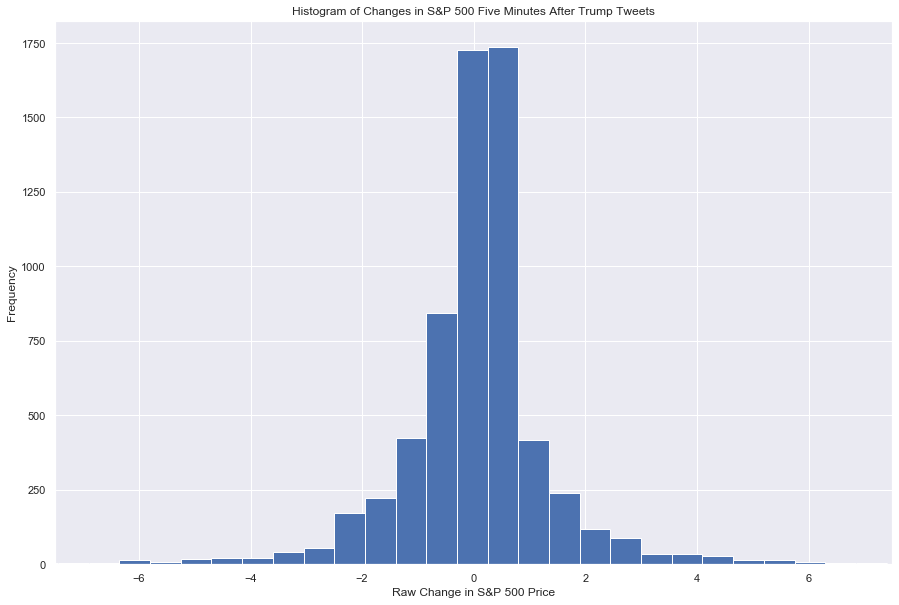

In [180]:
plt.figure(figsize=(15,10))
plt.hist(tweets_stock_viable['stock_dif'],bins=80)
plt.xlim(-7.5,7.5)
plt.title('Histogram of Changes in S&P 500 Five Minutes After Trump Tweets')
plt.ylabel('Frequency')
plt.xlabel('Raw Change in S&P 500 Price')

In [181]:
uptweets = tweets_stock_viable[tweets_stock_viable.stock_up == 1]
downtweets = tweets_stock_viable[tweets_stock_viable.stock_dif == 0]

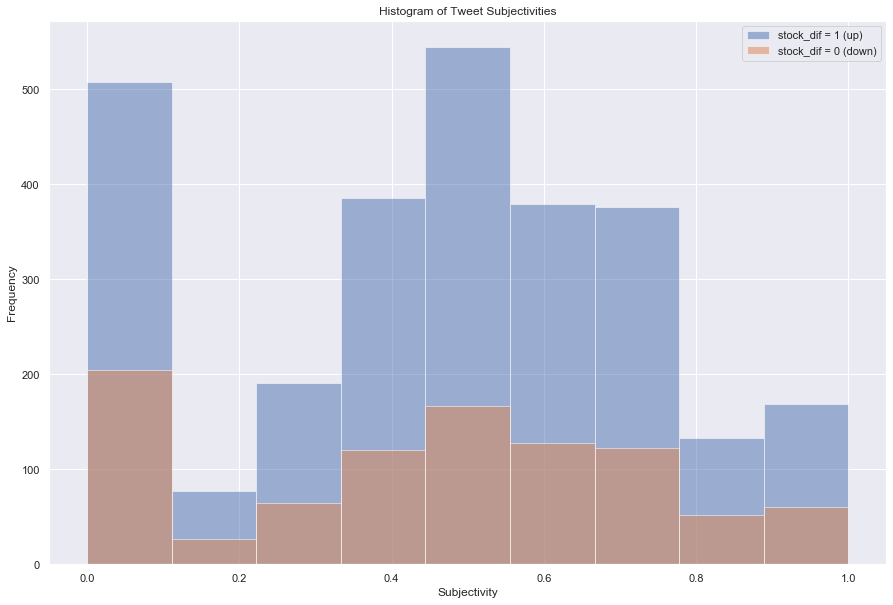

In [182]:
plt.figure(figsize=(15,10))
bins = np.linspace(0, 1, 10)

plt.hist(uptweets['subjectivity'], bins, alpha=0.5, label='stock_dif = 1 (up)')
plt.hist(downtweets['subjectivity'], bins, alpha=0.5, label='stock_dif = 0 (down)')
plt.legend(loc='upper right')
plt.title('Histogram of Tweet Subjectivities')
plt.ylabel('Frequency')
plt.xlabel('Subjectivity')
plt.show()


Text(0.5, 0, 'Polarity')

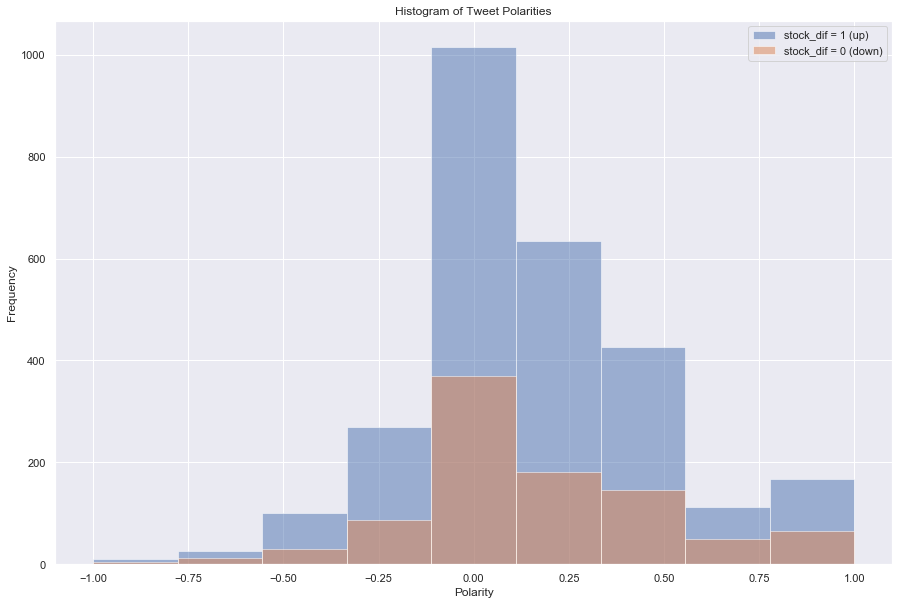

In [183]:
plt.figure(figsize=(15,10))


bins = np.linspace(-1, 1, 10)

plt.hist(uptweets['polarity'], bins, alpha=0.5, label='stock_dif = 1 (up)')
plt.hist(downtweets['polarity'], bins, alpha=0.5, label='stock_dif = 0 (down)')
plt.legend(loc='upper right')
plt.title('Histogram of Tweet Polarities')
plt.ylabel('Frequency')
plt.xlabel('Polarity')

In [184]:
most_impactful_tweets = tweets_stock_viable
most_impactful_tweets['stock_dif_magnitude'] = abs(most_impactful_tweets.stock_dif)
most_impactful_tweets = most_impactful_tweets.sort_values('stock_dif_magnitude', ascending=False)


for i in range(20):
    print('text: \n\t', most_impactful_tweets.text.iloc[i])
    print('\nchange in S&P 500 after 5 minutes: \n', tweets_stock_viable.stock_dif.loc[most_impactful_tweets.index[i]])
    print('\n')

text: 
	 ....better off without them. The vast amounts of money made and stolen by China from the United States year after year for decades will and must STOP. Our great American companies are hereby ordered to immediately start looking for an alternative to China including bringing..

change in S&P 500 after 5 minutes: 
 22.25


text: 
	 ....your companies HOME and making your products in the USA. I will be responding to China‚Äôs Tariffs this afternoon. This is a GREAT opportunity for the United States. Also I am ordering all carriers including Fed Ex Amazon UPS and the Post Office to SEARCH FOR &amp; REFUSE....

change in S&P 500 after 5 minutes: 
 22.25


text: 
	 Our Country has lost stupidly Trillions of Dollars with China over many years. They have stolen our Intellectual Property at a rate of Hundreds of Billions of Dollars a year &amp; they want to continue. I won‚Äôt let that happen! We don‚Äôt need China and frankly would be far....

change in S&P 500 after 5 minutes: 
 22.2